# <center> Assignment 1 | M&Ms
<center> Faculty of Engineering, University of Porto Master in Data Science and Enginnering

<center> Francisco Cuervo up202302145 | Silvia Tavares up202204392.

<center> Computer Vision, October 2023:

The quality assurance tester of a M&M factory retrieves a sample from the
production every hour to determine some properties of chocolate peanuts. The
factory uses a computer vision application to automatically calculate some
properties of the sample, namely:
- the distribution of each color in the sample, e.g., the number of red (or
blue or …) chocolates. At the end, if the sample does not have chocolate
peanuts of all colors, the system must raise an alarm by printing “Color
XPTO is missing”.
- the average shape area of all chocolate peanuts in millimeters and
organized by color.

# Mount google drive

The colab notebook mounts a google drive to access the images.

It assumes that the main folder is:
* MyDrive/Assignment_01

And the images are stored in folder:
* /CV_Assig_1/

In case it's not, it will ask for a path.

Inside this folder there must be:
* /IntrinsicCalibration/
* /WhiteBackground/
* /GreyBackground/

In [1]:
from google.colab import drive
from google.colab import files
import os

connected = False
drive.mount('/content/drive/', force_remount=True)

while not connected:

    try:
        os.chdir('/content/drive/My Drive/CV_Assig_1/')
        connected = True

    except :
        try:
          set_path = input('Insert your path: ')
          os.chdir(set_path)
          connected = True
        except :
          print('Invalide path, try again.')

    finally:
        continue

wdir = os.getcwd()

print(wdir)


Mounted at /content/drive/
/content/drive/My Drive/CV_Assig_1


Considering these requirements:

a) Calibrate the intrinsic parameters and lens distortion of the camera. Show
the intrinsic matrix and the lens distortion coefficients.

Information about the chessboard: 5x8 squares and size of a square = 21mm

In [2]:
import numpy as np
import cv2 as cv
import glob
from google.colab.patches import cv2_imshow
import pandas as pd
from matplotlib import pyplot as plt
import copy

In [3]:

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# chess pattern dimensions (square_rows x square_cols squares)
square_rows = 8 - 1 # -1 to account for internal corners
square_cols = 5 - 1

# prepare object points
objp = np.zeros((square_rows*square_cols,3), np.float32)
objp[:,:2] = np.mgrid[0:square_rows,0:square_cols].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# change directory
os.chdir(wdir + '/IntrinsicCalibration')

images = glob.glob('*.png')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (square_rows,square_cols), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (square_rows,square_cols), corners2, ret)
        cv2_imshow(img)
        print(f'{fname}: {img.shape}')
        cv.waitKey(500)

cv.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
ntargets = len(objpoints)
print(f'Number of valid images: {ntargets}')

Number of valid images: 36


Calibration
Now that we have our object points and image points, we are ready to go for calibration. We can use the function, cv.calibrateCamera() which returns the camera matrix, distortion coefficients, rotation and translation vectors etc.


In [5]:
# Calibration
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Show the intrinsic matrix and distortion coefficients
print("Intrinsic Matrix:")
print(mtx)
print("\nDistortion Coefficients:")
print(dist)

Intrinsic Matrix:
[[1.32164961e+03 0.00000000e+00 9.88299668e+02]
 [0.00000000e+00 1.32444624e+03 6.42259078e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
[[-3.44269790e-01  9.00566070e-02  9.45585473e-05 -3.97940160e-04
  -3.15658830e-03]]


## Extrinsic calibration

b) Calibrate the extrinsic parameters of the camera setup (or instead, use
the extrinsic image to manually measure the dimensions of a black
square of the chessboard in pixels. In this way, you will know the
conversion between pixel to millimeter). Show the extrinsic matrix
(rotation, translation, etc) and/or the conversion ratio between pixel to
millimeter that was used

#### Undistorted image

In [6]:
# change directory
os.chdir(wdir + '/WhiteBackground')

In [7]:
# Undistortion

def corr_images(img, fname, ret, mtx, dist, rvecs, tvecs):

  h,  w = img.shape[:2]
  newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

  # undistort
  udst = cv.undistort(img, mtx, dist, None, newcameramtx)
  # crop the image
  x, y, w, h = roi
  udst = udst[y:y+h, x:x+w]


# split the image in channels
  channels = cv.split(udst)

  for channel in channels:
    channel = cv.equalizeHist(channel)

  # merge the channels
  udst  = cv.merge(channels)

  # write image to file
  #cv.imwrite(fname[:-4] + '_corr.png', udst)


  return udst

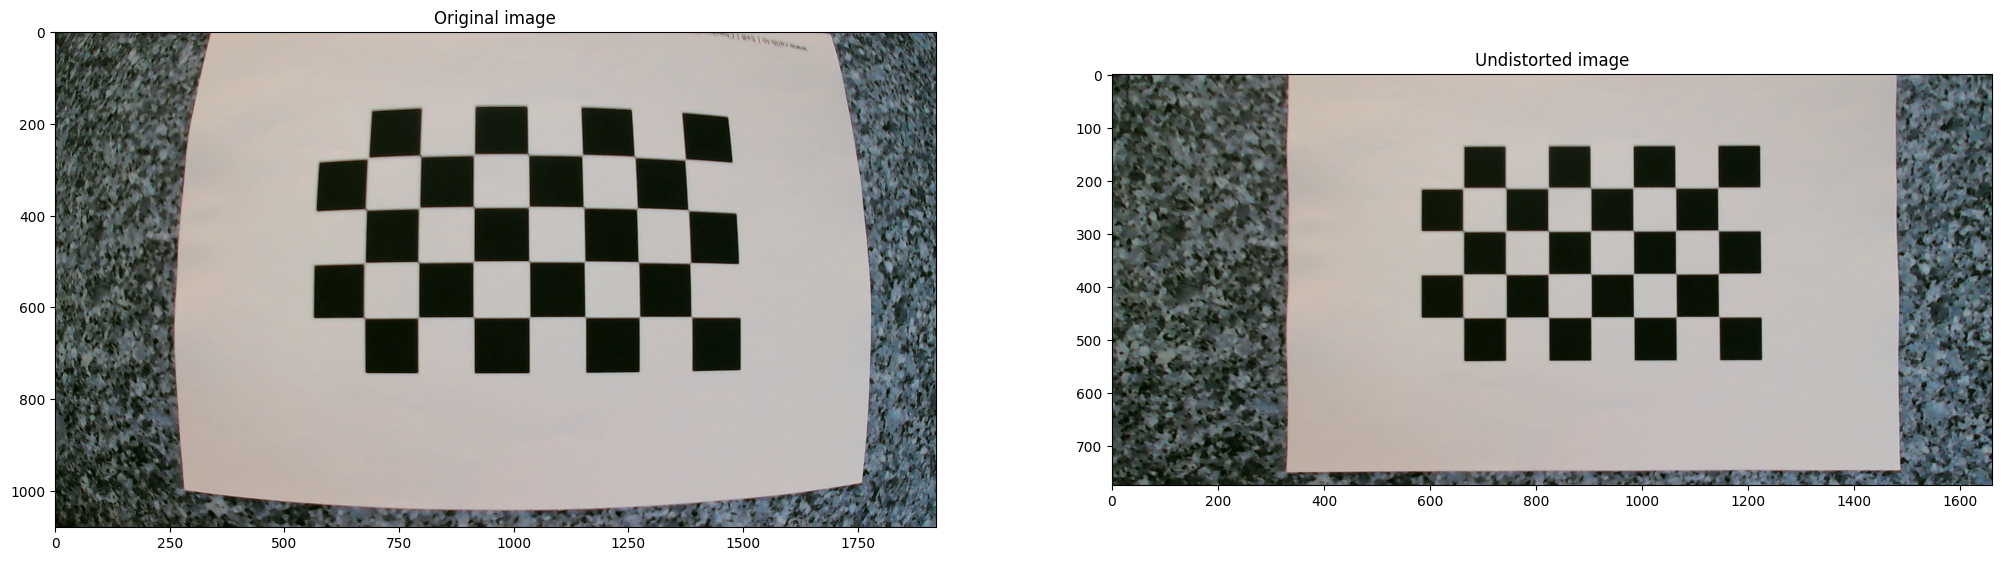

In [8]:
fname   = 'extrinsic.png'

# load image
img = cv.imread(fname)

dst = corr_images(img, fname, ret, mtx, dist, rvecs, tvecs)

# Deep copy of undistorted image to be used later on
pattern_corr = copy.deepcopy(dst)

#show image

plt.figure(figsize=(25, 15))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.title("Undistorted image")
plt.show()

# Pixels to mm^2 conversion

In [9]:
def print_imgs(img,title):
  print(title)
  cv2_imshow(img)
  cv.waitKey(0)
  cv.destroyAllWindows()

ROI of pattern


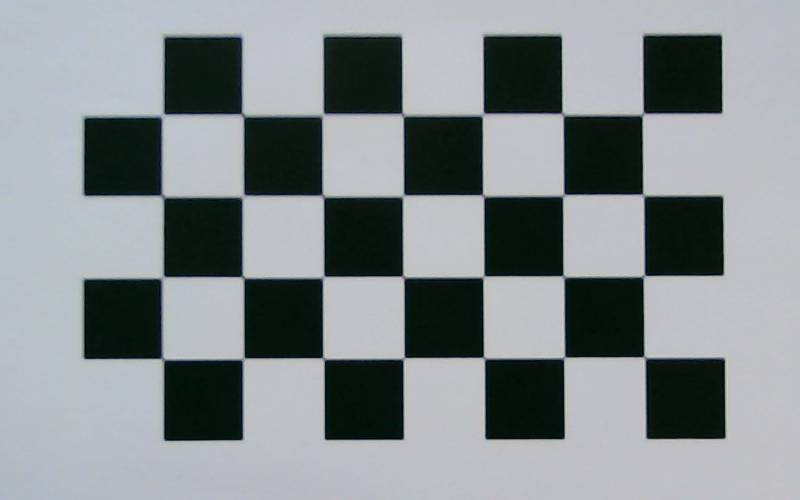

In [10]:
# Coordinates of ROI - This cordinate was obtained by analyzing the undistorted image (printed above on right)
x_min = 500
y_min = 100
x_max = 1300
y_max = 600

# Gets the ROI of the pattern image
cm_img = pattern_corr[y_min:y_max,x_min:x_max]

title = 'ROI of pattern'
print_imgs(cm_img,title)

Bounding box of pattern


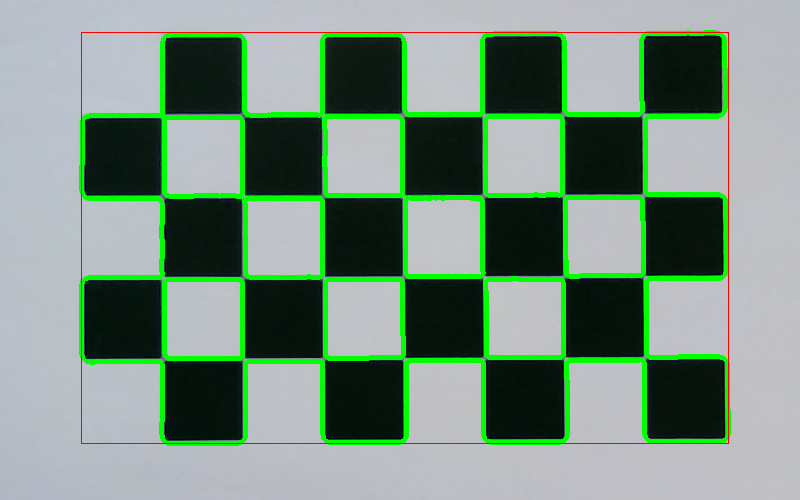

Pattern width:647
Square side in pixels:80.875
Conversion rate: 0.06633648845316396 mm^2 per pixel


In [11]:
# Identify contours of chess board to calculate the size of each square in pixels

def brg_to_grayscale(bgr_img):
  grayimage = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)
  blur = cv.blur(grayimage,(10,10),0)
  return blur, grayimage

# Grayscale
cm_blur, cm_graysc = brg_to_grayscale(cm_img)
cm_ret, cm_thresh = cv.threshold(cm_blur,150,255,cv.THRESH_BINARY_INV)

# find contours in the pattern
cm_contours, cm_hierarchy = cv.findContours(cm_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

cm_img_contours = np.zeros(cm_thresh.shape)
cm_z_hsv = cv.drawContours(cm_img, cm_contours, -1, (0, 255, 0), 3)

# identifies the max and min dimensions
cm_cnt = cm_contours[0]
cm_extLeft = tuple(cm_cnt[cm_cnt[:, :, 0].argmin()][0])
cm_extRight = tuple(cm_cnt[cm_cnt[:, :, 0].argmax()][0])
cm_extBottom = tuple(cm_cnt[cm_cnt[:, :, 1].argmin()][0])
cm_extTop = tuple(cm_cnt[cm_cnt[:, :, 1].argmax()][0])

cm_minx = cm_extLeft[0]
cm_maxx = cm_extRight[0]
cm_miny = cm_extBottom[1]
cm_maxy = cm_extTop[1]

# plot the bounding box
cv.rectangle(cm_img,(cm_minx,cm_miny),(cm_maxx,cm_maxy),(0,0,255),1)
title = 'Bounding box of pattern'
print_imgs(cm_img,title)

# Chess size
size_px = cm_maxx - cm_minx
# Square average
size_mm = size_px / 8

print(f'Pattern width:{size_px}')
print(f'Square side in pixels:{size_mm}')

total_pixels = abs(cm_maxx-cm_minx) * abs(cm_maxy-cm_miny)
total_area = (8*21)*(5*21)
conv = total_area / total_pixels
print(f'Conversion rate: {conv} mm^2 per pixel')

In [12]:
# measured in GIMP

conv2 = (21 * 21) / (79 *79)
print(f'Conversion rate (GIMP): {conv2} mm^2 per pixel')

Conversion rate (GIMP): 0.07066175292421087 mm^2 per pixel


c) Consider only the images retrieved from a White Background.
Implement the functions described above.

I. Define a ROI (region of interest) for the image;

In [13]:
# Path to the directory containing the images
images_directory = (wdir + '/WhiteBackground')

Original Image Shape: (135, 240, 3)
ROI Shape: (50, 50, 3)


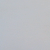

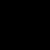

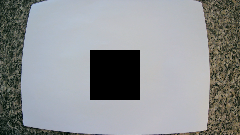

In [14]:
# Get the list of files in the directory
files = os.listdir(images_directory)

# Read the first image from the directory
if files:
    # Build the full path of the first image
    image_path = os.path.join(images_directory, files[0])

    # Read the image using OpenCV
    image_bgr = cv.imread(image_path, cv.IMREAD_REDUCED_COLOR_8)

    # Check if the image is loaded successfully
    if image_bgr is not None:
        # Print original image shape
        print("Original Image Shape:", image_bgr.shape)

        # Define ROI coordinates (x, y, width, height)
        roi_x, roi_y, roi_width, roi_height = 90, 50, 50, 50

        # Extract ROI from the original image
        my_roi = image_bgr[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]

        # Print ROI shape
        print("ROI Shape:", my_roi.shape)

        # Display the ROI
        cv2_imshow(my_roi)

        # Clear pixels in ROI (set ROI to black)
        my_roi[:, :] = [0, 0, 0]

        # Display the modified ROI
        cv2_imshow(my_roi)

        # Display the modified original image
        cv2_imshow(image_bgr)

    else:
        print("Error: Failed to load the first image from the directory.")
else:
    print("Error: No images in the provided directory.")


II. Calculate the number of M&M per color for all images provided;



In [15]:
# Define the color ranges for each type of M&M in HSV
color_ranges = {
    'red': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([35, 50, 50]), np.array([85, 255, 255]))
}

# Function to count M&Ms of a specific color in an image
def count_mm_color(image, color_range):
    # Convert image to HSV color space
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    # Create a mask using the specified color range
    mask = cv.inRange(hsv_image, color_range[0], color_range[1])

    # Apply morphological transformations (optional) to reduce noise
    kernel = np.ones((5,5),np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter contours by minimum area
    min_area = 500
    filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]

    return len(filtered_contours)

# Read images from the directory and count M&Ms by color in each image
mm_data = []

files = os.listdir(images_directory)
for file in files:
    image_path = os.path.join(images_directory, file)
    image = cv.imread(image_path)
    if image is not None:
        # Count M&Ms of each color in the image
        mm_counts = {color: count_mm_color(image, color_range) for color, color_range in color_ranges.items()}
        mm_data.append(mm_counts)

        # Show the original image
        cv2_imshow(image)

        # Print counting results for each color
        print(f"Results for the image: {file}")
        for color, count in mm_counts.items():
            print(f"Number of {color} M&Ms: {count}")

# Convert the data to a pandas DataFrame for further analysis
df = pd.DataFrame(mm_data)
print(df)


Output hidden; open in https://colab.research.google.com to view.

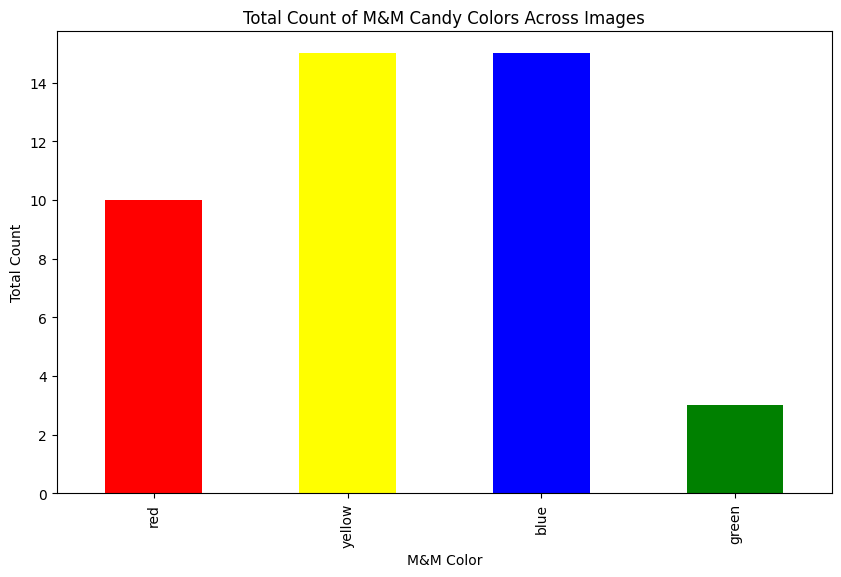

In [16]:
# Perform a group-by operation to sum the counts of each color
grouped_df = df.sum()

# Create a bar chart
grouped_df.plot(kind='bar', color=['red', 'yellow', 'blue', 'green'],figsize=(10, 6), legend=None)

# Add labels and title
plt.xlabel('M&M Color')
plt.ylabel('Total Count')
plt.title('Total Count of M&M Candy Colors Across Images')

# Show the chart
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.show()

III. Determine the average area for peanuts in pixels, considering the
image “calib_img 3”;

i. Show all peanuts that were detected.

In [17]:

# Path to the image calib_img 3
image_path = (wdir + '/WhiteBackground/calib_img 3.png')

# Define the color ranges for each type of peanut in HSV

color_ranges = {
    'red': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([31, 100, 100]), np.array([80, 255, 255]))
}

# Function to count peanuts of a specific color in an image
def count_peanuts_color(image, color_range):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_image, color_range[0], color_range[1])
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    min_area = 100
    filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]
    return filtered_contours

# Load the image calib_img 3
image_calib3 = cv.imread(image_path)

# Detect peanuts in the image calib_img 3 for the specified colors
detected_peanuts = {}
for color, color_range in color_ranges.items():
    peanuts_color = count_peanuts_color(image_calib3, color_range)
    detected_peanuts[color] = peanuts_color

# Apply shape detection on the detected peanuts
for color, peanut_contours in detected_peanuts.items():
    for peanut_contour in peanut_contours:
        # Detect shapes using contours
        epsilon = 0.04 * cv.arcLength(peanut_contour, True)
        approx = cv.approxPolyDP(peanut_contour, epsilon, True)
        num_corners = len(approx)

        # Classify shapes based on the number of corners
        shape = "circle"
        if num_corners == 3:
            shape = "triangle"
        elif num_corners == 4:
            shape = "rectangle"

        # Draw the shape label on the image
        x, y, w, h = cv.boundingRect(peanut_contour)
        cv.putText(image_calib3, f'{color}', (x, y - 10),
                    cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        print(f'{color} M&M')

# Show the image with the detected peanuts and shapes
cv2_imshow(image_calib3)
cv.waitKey(0)
cv.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Path to the image calib_img 3
image_path = (wdir + '/WhiteBackground/calib_img 3.png')

# Define the color ranges for each type of peanut in HSV
color_ranges = {
    'red': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([31, 100, 100]), np.array([80, 255, 255]))
}

# Function to count peanuts of a specific color in an image
def count_peanuts_color(image, color_range):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_image, color_range[0], color_range[1])
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter contours by minimum area
    min_area = 100  # Adjust the value according to the minimum size a peanut should have
    filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]

    return filtered_contours

# Load the image calib_img 3
image_calib3 = cv.imread(image_path)

# Detect peanuts in the image calib_img 3 for the specified colors
detected_peanuts = {}
for color, color_range in color_ranges.items():
    peanuts_color = count_peanuts_color(image_calib3, color_range)
    detected_peanuts[color] = peanuts_color
# Draw contours and mark shapes and areas on the original image with ovals
image_with_ovals = image_calib3.copy()
for color, peanut_contours in detected_peanuts.items():
    for peanut_contour in peanut_contours:
        # Fit an ellipse to the contour
        ellipse = cv.fitEllipse(peanut_contour)

        # Draw the ellipse on the image
        cv.ellipse(image_with_ovals, ellipse, (0, 255, 0), 2)

        # Calculate and display the area of the peanut
        peanut_area = cv.contourArea(peanut_contour)
        x, y, w, h = cv.boundingRect(peanut_contour)
        cv.putText(image_with_ovals, f'Area: {peanut_area:.2f} px^2', (x, y - 10),
                    cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Mark the shape (circle, triangle, rectangle) of the peanut
        epsilon = 0.04 * cv.arcLength(peanut_contour, True)
        approx = cv.approxPolyDP(peanut_contour, epsilon, True)
        num_corners = len(approx)
        shape = "circle"
        if num_corners == 3:
            shape = "triangle"
        elif num_corners == 4:
            shape = "rectangle"
        cv.putText(image_with_ovals, f'Shape: {shape}', (x, y - 30),
                    cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        print(f'Area of {color} peanut: {peanut_area} px^2, Shape: {shape}')


# Show the image with detected peanuts and contours marking the shape and area using ovals
cv2_imshow(image_with_ovals)
cv.waitKey(0)
cv.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.

ii. Discuss the limitations of the peanut detection method used
(in 2 sentences).

The peanut detection method used in this code is based on color and shape has some limitations:

Color Variation: It heavily relies on color information in the HSV color space. If the peanuts have subtle color variations or are affected by lighting conditions, it may lead to false positives or missed detections.

Minimum Area Filtering and Real-Time Processing: The code filters contours based on a minimum area (min_area = 100) to remove small contours. This threshold may not be suitable for all images and peanut sizes. Large peanuts might be incorrectly filtered out, or small objects unrelated to peanuts could be detected. Also, it designed for offline image processing. If we intend to use it in a real-time system, it may not be efficient enough.

IV. Determine the average area (and standard deviation) for peanuts
in millimeters and grouped by color, considering images “calib_img
2” and “calib_img 3”.

i. Show the result in a table color vs area and standard
deviation.

In [19]:

# Paths to calib_img 2 and calib_img 3 images
image_path2 = (wdir + '/WhiteBackground/calib_img 2.png')
image_path3 = (wdir + '/WhiteBackground/calib_img 3.png')

# Define color ranges for each type of peanut in HSV
color_ranges = {
    'red': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([31, 100, 100]), np.array([80, 255, 255]))
}

# Function to count peanuts of a specific color in an image
def count_peanuts_color(image, color_range):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_image, color_range[0], color_range[1])
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter contours by area and shape
    min_area = 100  # Minimum size a peanut should have
    max_aspect_ratio = 1.5  # Maximum aspect ratio for a peanut
    filtered_contours = []
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > min_area:
            x, y, w, h = cv.boundingRect(cnt)
            aspect_ratio = float(w) / h
            if 1 / max_aspect_ratio < aspect_ratio < max_aspect_ratio:
                filtered_contours.append(cnt)

    return filtered_contours

# Function to calculate area in square millimeters
def calculate_area_mm2(area_px2, mm_px_ratio):
    return area_px2 * mm_px_ratio**2

# Load calib_img 2 and calib_img 3 images
image_calib2 = cv.imread(image_path2)
image_calib3 = cv.imread(image_path3)

# Calibrate the pixel-to-millimeter ratio (adjust this value according to your data)
mm_px_ratio = 0.1  # For example, if 1 pixel = 0.1 mm

# Calculate peanut areas in square millimeters for both images and group by color
areas_by_color_calib2 = {}
areas_by_color_calib3 = {}

for color, color_range in color_ranges.items():
    peanuts_calib2 = count_peanuts_color(image_calib2, color_range)
    peanuts_calib3 = count_peanuts_color(image_calib3, color_range)

    areas_calib2 = [calculate_area_mm2(cv.contourArea(c), mm_px_ratio) for c in peanuts_calib2]
    areas_calib3 = [calculate_area_mm2(cv.contourArea(c), mm_px_ratio) for c in peanuts_calib3]

    areas_by_color_calib2[color] = areas_calib2
    areas_by_color_calib3[color] = areas_calib3

data_2 = []
# Calculate average area and standard deviation for each color and each image
for color, areas in areas_by_color_calib2.items():
    average_area_calib2 = np.mean(areas)
    standard_deviation_calib2 = np.std(areas)
    data_2.append([color, average_area_calib2, standard_deviation_calib2])

# Create a DataFrame
df_2 = pd.DataFrame(data_2, columns=['Color', 'Average Area (mm^2) - Calib 2', 'Standard Deviation (mm^2) - Calib 2'])
df_2



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Color,Average Area (mm^2) - Calib 2,Standard Deviation (mm^2) - Calib 2
0,red,47.04875,7.657905
1,yellow,73.46400,10.520580
2,blue,58.43700,11.111377
3,green,NaN,NaN


In [20]:
data = []
for color, areas in areas_by_color_calib3.items():
    average_area_calib3 = np.mean(areas)
    standard_deviation_calib3 = np.std(areas)
    data.append([color, average_area_calib3, standard_deviation_calib3])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Color', 'Average Area (mm^2) - Calib 3', 'Standard Deviation (mm^2) - Calib 3'])

# Display the DataFrame
print(' ')
df

,Color,Average Area (mm^2) - Calib 3,Standard Deviation (mm^2) - Calib 3
0,red,45.30625,7.906305
1,yellow,71.90600,10.668934
2,blue,58.42000,15.234593
3,green,25.55000,10.462534


In [21]:
# Directory containing calib_img 2 and calib_img 3 images
images_directory = (wdir + '/WhiteBackground')

# List of images to process
files_to_process = ['calib_img 2.png', 'calib_img 3.png']

# Define color ranges for each type of peanut in HSV
color_ranges = {
    'red': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([31, 100, 100]), np.array([80, 255, 255]))
}

# Function to calculate areas and standard deviations
def calculate_areas_standard_deviations(images_directory, files_to_process, color_ranges):
    data = []
    for file in files_to_process:
        image_path = os.path.join(images_directory, file)
        image = cv.imread(image_path)
        if image is not None:
            image_results = {'File': file}
            for color, color_range in color_ranges.items():
                peanuts_color = count_peanuts_color(image, color_range)
                areas = [cv.contourArea(peanut) for peanut in peanuts_color]
                # Calculate average area and standard deviation
                if areas:
                    image_results[f'{color}_areas'] = areas
                    image_results[f'{color}_average_area'] = np.mean(areas)
                    image_results[f'{color}_standard_deviation'] = np.std(areas)
                else:
                    image_results[f'{color}_areas'] = []
                    image_results[f'{color}_average_area'] = np.nan
                    image_results[f'{color}_standard_deviation'] = np.nan
            data.append(image_results)
    return pd.DataFrame(data)

# Call the function to calculate areas and standard deviations
df_results = calculate_areas_standard_deviations(images_directory, files_to_process, color_ranges)

# Display the DataFrame
print(df_results)


              File                         red_areas  red_average_area  \
0  calib_img 2.png  [4681.0, 5938.5, 3886.0, 4314.0]          4704.875   
1  calib_img 3.png  [4447.0, 5813.5, 3677.5, 4184.5]          4530.625   

   red_standard_deviation                              yellow_areas  \
0              765.790472  [7145.0, 9326.0, 6441.0, 6477.5, 7342.5]   
1              790.630474  [6940.0, 9246.5, 6459.5, 6272.5, 7034.5]   

   yellow_average_area  yellow_standard_deviation  \
0               7346.4                1052.057955   
1               7190.6                1066.893359   

                                 blue_areas  blue_average_area  \
0  [6087.5, 4001.0, 6704.5, 7136.0, 5289.5]             5843.7   
1  [7839.5, 3947.5, 4572.0, 7356.0, 5495.0]             5842.0   

   blue_standard_deviation               green_areas  green_average_area  \
0              1111.137732                        []                 NaN   
1              1523.459320  [3461.5, 3114.5, 1089.0]

ii. Discuss the limitation of the method implemented (in 2
sentences).

The implemented method relies on contour detection to calculate peanut areas, which might be sensitive to varying lighting conditions and peanut orientations, leading to inconsistent results. Additionally, the method does not account for overlapping peanuts, potentially underestimating the actual peanut count and area.

 V. Provide some recommendations that the M&M factory should take
into consideration to improve the performance of the quality
assurance process based on image processing (e.g., imaging
setup, calibration process and photometric effects), in 4 sentences.

To enhance the quality assurance process, the M&M factory should invest in a consistent and controlled imaging setup, ensuring uniform lighting conditions and minimal shadows. Implementing a rigorous calibration process, accounting for camera intrinsic parameters and lens distortion, is crucial for accurate measurements. Additionally, considering photometric effects such as reflections and surface textures during color detection can refine the algorithm's precision. Regular maintenance of the imaging equipment and continuous monitoring of image quality will ensure sustained accuracy in peanut inspection, allowing for timely adjustments and improvements in the production line.

d) Consider the images retrieved from a Grey Background and
repeat the previous point without defining a region of interest.

NUMBER OF M&MS

In [22]:
# Path to the directory containing the M&M images
images_directory = (wdir + '/GreyBackground')

# Define the color ranges for each type of M&M in HSV
color_ranges = {
    'red': (np.array([0, 68, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([35, 50, 50]), np.array([85, 255, 255])),
    'brown': (np.array([0, 50, 50]), np.array([10, 255, 255]))
}

# Function to count M&Ms of a specific color in an image
def count_mm_color(image, color_range):
    # Convert image to HSV color space
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    # Create a mask using the specified color range
    mask = cv.inRange(hsv_image, color_range[0], color_range[1])

    # Apply morphological transformations (optional) to reduce noise
    kernel = np.ones((5,5),np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter contours by minimum area
    min_area = 500  # Adjust the value according to the minimum size an M&M should have
    filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]

    return len(filtered_contours)

# Read images from the directory and count M&Ms by color in each image
files = os.listdir(images_directory)
mm_data = []

for file in files:
    image_path = os.path.join(images_directory, file)
    image = cv.imread(image_path)

    if image is not None:
        # Initialize dictionary to count M&Ms of each color in this image
        mm_counts = {color: count_mm_color(image, color_range) for color, color_range in color_ranges.items()}
        mm_data.append(mm_counts)

        # Show the original image
        cv2_imshow(image)

        # Print counting results for each color
        print(f"Results for the image: {file}")
        for color, count in mm_counts.items():
            print(f"Number of {color} M&Ms: {count}")

# Convert the data to a pandas DataFrame for further analysis
df = pd.DataFrame(mm_data)
print(df)


Output hidden; open in https://colab.research.google.com to view.

M&MS DETECTION

In [23]:

# Path to the image calib_img 4
image_path = (wdir + '/GreyBackground/calib_img 4.png')

# Define the color ranges for each type of peanut in HSV
color_ranges = {
    'red': (np.array([0, 68, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'green': (np.array([35, 50, 50]), np.array([85, 255, 255])),
    'brown': (np.array([0, 50, 50]), np.array([10, 255, 255]))   # Adjusted Brown color range
}

# Function to count peanuts of a specific color in an image
def count_peanuts_color(image, color_range):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_image, color_range[0], color_range[1])

    # Apply morphological transformations (optional) to reduce noise
    kernel = np.ones((5, 5), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter contours by minimum area
    min_area = 100
    filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]

    return filtered_contours

# Load the image calib_img 4
image_calib4 = cv.imread(image_path)

# Detect peanuts in the image calib_img 4 for the specified colors
detected_peanuts = {}
for color, color_range in color_ranges.items():
    peanuts_color = count_peanuts_color(image_calib4, color_range)
    detected_peanuts[color] = peanuts_color

# Show the detected peanuts in the image calib_img 4
image_with_peanuts = image_calib4.copy()
for color, peanut_contours in detected_peanuts.items():
    for peanut_contour in peanut_contours:
        cv.drawContours(image_with_peanuts, [peanut_contour], -1, (0, 255, 0), 2)

        # Calculate and display the area of the peanut
        peanut_area = cv.contourArea(peanut_contour)
        x, y, w, h = cv.boundingRect(peanut_contour)
        cv.putText(image_with_peanuts, f'Area: {peanut_area:.2f} px^2', (x, y - 10),
                    cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        print(f'Area of {color} peanut: {peanut_area} px^2')

# Show the image with the detected peanuts
cv2_imshow(image_with_peanuts)
cv.waitKey(0)
cv.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

The detection method relies on the color information in the image to segment and identify the peanuts based on their color. The detected contours are used to determine the number of peanuts of each color and other relevant information, such as their areas.

This method is useful for scenarios where the color of objects is a distinguishing feature, but it did not work well because the lighting conditions or object appearances vary significantly.


AVERAGE AND STANDARD DEVIATION

In [24]:
# Directory containing images calib_img 2 and calib_img 3
images_directory = (wdir + '/GreyBackground')

# List of images to process
files_to_process = ['calib_img 4.png', 'calib_img 3.png']

# Define color ranges for each type of peanut in HSV
color_ranges = {
    'red': (np.array([0, 120, 70]), np.array([10, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'green': (np.array([35, 50, 50]), np.array([85, 255, 255])),
    'blue': (np.array([100, 100, 100]), np.array([140, 255, 255])),
    'brown': (np.array([10, 50, 50]), np.array([20, 255, 255]))  # Brown color range
}

# Function to calculate areas and standard deviations
def calculate_areas_standard_deviations(images_directory, files_to_process, color_ranges):
    data = []
    for file in files_to_process:
        image_path = os.path.join(images_directory, file)
        image = cv.imread(image_path)
        if image is not None:
            image_results = {'File': file}
            for color, color_range in color_ranges.items():
                peanuts_color = count_peanuts_color(image, color_range)
                areas = [cv.contourArea(peanut) for peanut in peanuts_color]
                # Calculate average area and standard deviation
                if areas:
                    image_results[f'{color}_areas'] = areas
                    image_results[f'{color}_average_area'] = np.mean(areas)
                    image_results[f'{color}_standard_deviation'] = np.std(areas)
                else:
                    image_results[f'{color}_areas'] = []
                    image_results[f'{color}_average_area'] = np.nan
                    image_results[f'{color}_standard_deviation'] = np.nan
            data.append(image_results)
    return pd.DataFrame(data)

# Call the function to calculate areas and standard deviations
df_results = calculate_areas_standard_deviations(images_directory, files_to_process, color_ranges)

# Display the DataFrame
print(df_results)


              File                                          red_areas  \
0  calib_img 4.png  [143.0, 160.5, 975.5, 134.0, 744.5, 607.0, 166...   
1  calib_img 3.png    [3282.0, 3968.0, 2512.5, 280.0, 3339.5, 2385.5]   

   red_average_area  red_standard_deviation  \
0        406.812500              305.584577   
1       2627.916667             1177.199977   

                                        yellow_areas  yellow_average_area  \
0  [2603.5, 3450.0, 110.0, 460.0, 4151.0, 2488.5,...          2599.428571   
1           [5441.5, 6600.0, 7302.5, 4857.0, 7592.0]          6358.600000   

   yellow_standard_deviation               green_areas  green_average_area  \
0                1663.178206  [5857.0, 5687.0, 3737.0]         5093.666667   
1                1055.118164  [7504.5, 6707.5, 4205.5]         6139.166667   

   green_standard_deviation  \
0                961.815413   
1               1405.489792   

                                          blue_areas  blue_average_area  \
0 